#YCBS258

##Assignment #4

Vincent Roy ID : 119244546


# MNIST Autoencoder
### Directives
* Create the autoencoders described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)
3. VAE


In [1]:
# Choose Python 3 runtime
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 51.1MB/s 
     |████████████████████████████████| 450kB 53.0MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
ERROR: tensorboard 2.0.1 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.1 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [2]:
# import all of th libraries to create and run the models
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

tf.__version__

Using TensorFlow backend.


'2.0.0'

In [3]:
# import the mnist data set and combine the test and the train data
(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

(70000, 28, 28)

In [0]:
# convert the data to float 32 and normalize by dividing by 255
all_data = all_data.astype(np.float32) / 255
X_train, X_valid = all_data[:-5000], all_data[-5000:]

In [5]:
# ensure that the shape of the data set is ok
X_train.shape

(65000, 28, 28)

In [0]:
# function used to print the the first 9 digits of the data set
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.xticks([])
    plt.yticks([])

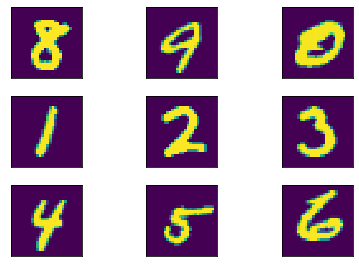

In [7]:
print_first_9(all_data[-9:])

In [0]:
# helper functon to display the original image with respect to the reconstructed image
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        

In [0]:
# helper function to plot an image
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

##Problem 1

Creation of a stacked autoencoder with dense layer architecture as follows 784 - 392 - 196 - 392 - 784 and tied weights

####Note

I tried to program the tied autoencoder using the Functional API. However, this did not work so I finally used the sequential approach. You will find a working version of the sequential version below, as well as two attempts two create the model using the functional API. Note that I did sent an email for help but I got no response.

In [0]:
# this class enables us to tie the weights of a given layer to that of a previous layer in the autoencoder
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [0]:
# customized accuracy funtion
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [17]:
keras.backend.clear_session()
np.random.seed(42)

# create the stacked autoencoder with tied weights

# the encoder
dense_1 = keras.layers.Dense(784, activation="selu")
dense_2 = keras.layers.Dense(392, activation="selu")
dense_3 = keras.layers.Dense(196, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2,
    dense_3,
])


# the decoder
tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_3, activation="selu"),
    DenseTranspose(dense_2, activation="sigmoid"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])


# assemble the model
tiedAuto = keras.models.Sequential([tied_encoder, tied_decoder])

# compile and fit the model
tiedAuto.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tiedAuto.fit(X_train, X_train, epochs=10,
                      validation_data=[X_valid, X_valid])



Train on 65000 samples, validate on 5000 samples
Epoch 1/10
65000/65000 [==============================] - 47s 717us/sample - loss: 0.1651 - rounded_accuracy: 0.9350 - val_loss: 0.1293 - val_rounded_accuracy: 0.9555
Epoch 2/10
65000/65000 [==============================] - 46s 706us/sample - loss: 0.1181 - rounded_accuracy: 0.9599 - val_loss: 0.1104 - val_rounded_accuracy: 0.9636
Epoch 3/10
65000/65000 [==============================] - 45s 692us/sample - loss: 0.1047 - rounded_accuracy: 0.9665 - val_loss: 0.0997 - val_rounded_accuracy: 0.9703
Epoch 4/10
65000/65000 [==============================] - 45s 699us/sample - loss: 0.0981 - rounded_accuracy: 0.9698 - val_loss: 0.0945 - val_rounded_accuracy: 0.9730
Epoch 5/10
65000/65000 [==============================] - 46s 708us/sample - loss: 0.0937 - rounded_accuracy: 0.9721 - val_loss: 0.0913 - val_rounded_accuracy: 0.9740
Epoch 6/10
65000/65000 [==============================] - 47s 719us/sample - loss: 0.0906 - rounded_accuracy: 0.9737

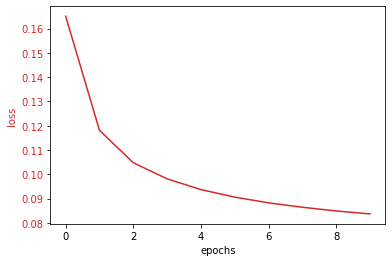

In [18]:
# summarize history for loss
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

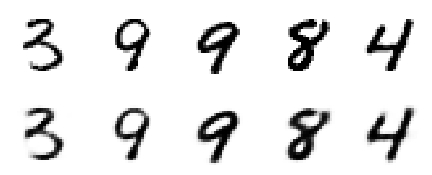

In [19]:
# show the actual images vs the reconstruction
show_reconstructions(tiedAuto)
plt.show()

In [0]:
# 1 attempt at functional tied autoencoder

keras.backend.clear_session()
np.random.seed(42)

inputs_1 = keras.Input(shape=(28,28))
re = Reshape([28, 28, 1], input_shape=[28, 28])(inputs_1)
dense_1 = keras.layers.Dense(784, activation="selu")(re)
dense_2 = keras.layers.Dense(392, activation="selu")(dense_1)
dense_3 = keras.layers.Dense(196, activation="selu")(dense_2)


denseTP_1 = DenseTranspose(dense_3, activation="selu")
denseTP_2 = DenseTranspose(dense_2, activation="sigmoid")
denseTP_3 = DenseTranspose(dense_1, activation="sigmoid")
final = Reshape([28, 28])(denseTP_3)


tied_decoder = keras.Model(inputs_1,final)


tied_decoder.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])


In [0]:
# 2 attempt at tied functional autoencoder

eInputs = keras.layers.Input(shape=[28, 28])
flat = keras.layers.Flatten()(eInputs)
d1 = keras.layers.Dense(784, activation="selu")(flat)
d2 = keras.layers.Dense(392, activation="selu")(d1)
d3 = keras.layers.Dense(196, activation="selu")(d2)

tiedEncoder = keras.models.Model(
    inputs=[eInputs], outputs=[d3])

dInputs = keras.layers.Input(shape=[196])
dt1 = DenseTranspose(d3, activation="selu")(dInputs)
dt2 = DenseTranspose(d2, activation="selu")(dt1)
dt3 = DenseTranspose(d1, activation="selu")(dt2)

tieDecoder = keras.models.Model(inputs=[dInputs], outputs=[dt3])


##Problem 2

Creation of a Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

inputs = Input(shape=(28,28))

# creation of the convolutional autoencoder

# encoder part
re = Reshape([28, 28, 1], input_shape=[28, 28])(inputs)
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(re)
x1 = MaxPool2D( (2, 2), padding='same')(x1)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2), padding='same')(x2)
x3 = Conv2D(16, (3, 3), activation='relu', padding='same')(x2)
encoded    = MaxPool2D( (2, 2), padding='same')(x3)

# decoding part
x3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x3)
x2 = UpSampling2D((2, 2))(x2)
x1 = Conv2D(64, (3, 3), activation='selu')(x2)
x1 = UpSampling2D((2, 2))(x1)
x0   = Conv2D(1, (3, 3),activation='sigmoid', padding='same')(x1)
out = Reshape([28, 28])(x0)


# asseembly of the model
convEncoderDecoder = keras.models.Model(inputs,out)

# summary to verify the structure
convEncoderDecoder.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624  

In [21]:
# compilation and training
convEncoderDecoder.compile(optimizer='adadelta', loss='binary_crossentropy')
history = convEncoderDecoder.fit(X_train, X_train, epochs=10,validation_data=[X_valid, X_valid])

Train on 65000 samples, validate on 5000 samples
Epoch 1/10
65000/65000 [==============================] - 372s 6ms/sample - loss: 0.5629 - val_loss: 0.4753
Epoch 2/10
65000/65000 [==============================] - 375s 6ms/sample - loss: 0.4106 - val_loss: 0.3817
Epoch 3/10
65000/65000 [==============================] - 376s 6ms/sample - loss: 0.3225 - val_loss: 0.2950
Epoch 4/10
65000/65000 [==============================] - 377s 6ms/sample - loss: 0.2662 - val_loss: 0.2601
Epoch 5/10
65000/65000 [==============================] - 377s 6ms/sample - loss: 0.2443 - val_loss: 0.2446
Epoch 6/10
65000/65000 [==============================] - 373s 6ms/sample - loss: 0.2318 - val_loss: 0.2334
Epoch 7/10
65000/65000 [==============================] - 370s 6ms/sample - loss: 0.2228 - val_loss: 0.2253
Epoch 8/10
65000/65000 [==============================] - 372s 6ms/sample - loss: 0.2160 - val_loss: 0.2191
Epoch 9/10
65000/65000 [==============================] - 378s 6ms/sample - loss: 0.210

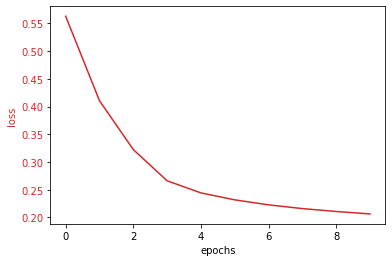

In [22]:
# summarize history for loss
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

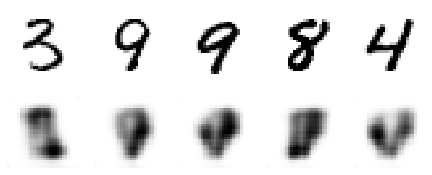

In [23]:
# show the actual images vs the reconstruction
show_reconstructions(convEncoderDecoder)
plt.show()

##Problem 3

Creation of a VAE autoencoder

In [0]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 500

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

vaeAutoencoder = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * tf.keras.backend.sum(
    1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean),
    axis=-1)
vaeAutoencoder.add_loss(tf.keras.backend.mean(latent_loss) / 784.)


# summary to verify the structure
vaeAutoencoder.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 500), (None, 233850      input_2[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 28, 28)       183634      model_1[1][2]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           input_2[0][0]                    
____________________________________________________________________________________________

In [26]:
# compile and train the autoencoder
vaeAutoencoder.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = vaeAutoencoder.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 65000 samples, validate on 5000 samples
Epoch 1/25
65000/65000 [==============================] - 17s 269us/sample - loss: 0.2450 - rounded_accuracy: 0.8938 - val_loss: 0.2136 - val_rounded_accuracy: 0.9177
Epoch 2/25
65000/65000 [==============================] - 16s 253us/sample - loss: 0.1996 - rounded_accuracy: 0.9217 - val_loss: 0.1920 - val_rounded_accuracy: 0.9295
Epoch 3/25
65000/65000 [==============================] - 16s 243us/sample - loss: 0.1868 - rounded_accuracy: 0.9303 - val_loss: 0.1817 - val_rounded_accuracy: 0.9362
Epoch 4/25
65000/65000 [==============================] - 16s 240us/sample - loss: 0.1768 - rounded_accuracy: 0.9365 - val_loss: 0.1714 - val_rounded_accuracy: 0.9408
Epoch 5/25
65000/65000 [==============================] - 16s 241us/sample - loss: 0.1651 - rounded_accuracy: 0.9429 - val_loss: 0.1600 - val_rounded_accuracy: 0.9477
Epoch 6/25
65000/65000 [==============================] - 16s 243us/sample - loss: 0.1568 - rounded_accuracy: 0.9476

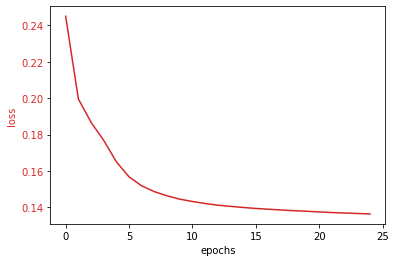

In [27]:
# summarize history for loss
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color=color)
ax1.plot(history.history['loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

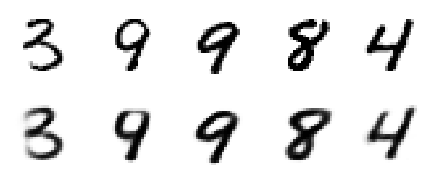

In [28]:
# show the actual images vs the reconstruction
show_reconstructions(vaeAutoencoder)
plt.show()